# Global constants

In [476]:
GRAIN_TYPE = 'WheatAdded_Type'
#GRAIN_TYPE = 'newWheatData'
#GRAIN_TYPE = 'CornAdded_Type'
#GRAIN_TYPE = 'cleaned_data'
# GRAIN_TYPE = 'Oats'

# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
# GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + '_t2_kcv_dnn_mc.h5'

In [477]:
#Import libraries
import requests
import pandas as pd
import kerastuner as kt

#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.10.0


In [478]:
print(tf.config.list_physical_devices('GPU'))
# print(tf.version.VERSION)

[]


## Helper functions

In [479]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(x=predictions, y=trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

In [480]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'SOUTH DAKOTA']
#df = df[(df['Density'] >= 0.72) & (df['Density'] <= 0.88)]

print("From USDA: ", URL)


df.head()

From USDA:  ../Datasets/processed/WheatAdded_Type.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
0,0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243,15.855506,-6.341975,62.3,61.7806
1,1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246,15.855506,-11.142320,71.2,82.0576
2,2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246,15.855506,-14.537729,80.1,104.1111
3,3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246,15.855506,10.470049,89.0,128.7950
4,4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238,15.855506,6.066299,97.9,151.4139


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [481]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Type',
                    'Phase/Attn',
                    ]]
df_targets = df[['Density']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [482]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize the entire dataset (input features)
dataset_x_norm = scaler_input.fit_transform(dataset_x)  # Use transform, NOT fit_transform

# Normalize the entire dataset (output targets)
dataset_y_norm = scaler_output.fit_transform(dataset_y)  # Use transform, NOT fit_transform


## Normalize datasets

In [483]:
# Perform train-test split on RAW DATA
# Splitting indices
train_idx, test_idx = train_test_split(df.index, test_size=0.20, random_state=42)

# Use indices to create datasets
X_train, X_test = dataset_x_norm[train_idx], dataset_x_norm[test_idx]
y_train, y_test = dataset_y_norm[train_idx], dataset_y_norm[test_idx]


## Defining and Running model with KCV

In [484]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import space_eval

# Assuming your dataset_x_norm and dataset_y_norm are already defined and preprocessed

# Define the space of hyperparameters to search
space = {
    'num_layers': hp.choice('num_layers', [5,6,7]),
    'units_per_layer': hp.choice('units_per_layer', [ 128,140, 180,256,300,350,400,450]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'epochs': hp.choice('epochs', [210,215,220,225]),
    'batch_size':hp.choice('batch_size', [8,10,16])
}

def objective(params):
    model = Sequential()
    model.add(Dense(params['units_per_layer'], input_dim=df_features.shape[1], activation='relu'))
    for _ in range(params['num_layers']):
        model.add(Dense(params['units_per_layer'], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    model.compile(optimizer=Adam(learning_rate=params['learning_rate']), loss='mean_squared_error')
    
    # Train the model with validation split
    history = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=params['epochs'], verbose=0, validation_split=0.15)
    
    # Use the history object to access the validation loss
    val_loss = np.amin(history.history['val_loss'])
    
    return {'loss': val_loss, 'status': STATUS_OK}

trials = Trials()
best = fmin(objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1500,  # Adjusted number of evaluations
            trials=trials)

# A more efficient way to retrieve the best parameters
best_params = space_eval(space, best)
print(f"Best hyperparameters: {best_params}")

# Retrain the model with the best hyperparameters
model = Sequential()
model.add(Dense(best_params['units_per_layer'], input_dim=df_features.shape[1], activation='relu'))
for _ in range(best_params['num_layers']):  # Adjust for initial layer
    model.add(Dense(best_params['units_per_layer'], activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']) ,loss='mean_squared_error')

# Assuming best_params['epochs'] and best_params['batch_size'] are properly defined
model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Save the model
model.save('best_model.h5')

print("Model saved as best_model.h5")

  0%|          | 0/1500 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 1500/1500 [8:48:38<00:00, 21.15s/trial, best loss: 0.00014121273125056177]  
Best hyperparameters: {'batch_size': 10, 'epochs': 225, 'learning_rate': 0.0005541384023326294, 'num_layers': 6, 'units_per_layer': 450}
Model saved as best_model.h5


# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

In [485]:
# Loss across k folds
print(best_params)

{'batch_size': 10, 'epochs': 225, 'learning_rate': 0.0005541384023326294, 'num_layers': 6, 'units_per_layer': 450}


### Loss curves

In [486]:
def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()



# # Loss across k folds
# plot_line(arr_loss, "Loss across k-folds", "Value of k")

# # Training and Validation Loss
# plot_loss_curve(history_best_model, NUM_EPOCHS)

# Prediction on Test Dataset

6/6 [==============================] - 0s 1ms/step


26/26 [==============================] - 0s 966us/step
Elapsed time: 0.102 seconds
Maxval here is:  0.9278


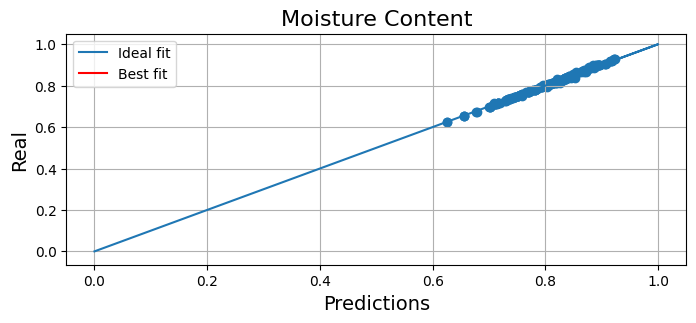

In [487]:
import time

start_time = time.time()
Y_pred_normalized = model.predict(X_test)
end_time = time.time()
Y_pred_normalized_entire = model.predict(dataset_x_norm)
# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")


Y_pred = scaler_output.inverse_transform(Y_pred_normalized)
Y_pred_entire = scaler_output.inverse_transform(Y_pred_normalized_entire)
Y_actual = scaler_output.inverse_transform(y_test)
Y_actual_entire = np.array(df_targets)
# Moisture Content
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_MC.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [488]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#   - R-squared
# mc_r2_score = r2_score(Y_actual[:, 0], Y_pred[:, 0])
mc_r2_score = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("{:#.4g}".format(mc_r2_score))




0.9970


### RMSE

In [489]:
from sklearn.metrics import mean_squared_error
from sigfig import round
def print_variety_counts(df, train_idx, test_idx, variety_column='Variety'):
    # Extracting varieties based on indices
    train_varieties = df.loc[train_idx, variety_column]
    test_varieties = df.loc[test_idx, variety_column]
    
    # Counting occurrences
    train_counts = train_varieties.value_counts()
    test_counts = test_varieties.value_counts()
    
    # Printing
    print("Training Set Variety Counts:")
    print(train_counts, "\n")
    print("Testing Set Variety Counts:")
    print(test_counts)

def calculate_errors_by_variety(df, Y_pred, Y_actual, test_idx, variety_column='Variety'):
    # Create DataFrame from test_idx to map back to original df
    test_varieties = df.loc[test_idx, variety_column].reset_index(drop=True)
    
    # Convert predictions and actual values to DataFrame
    predictions_df = pd.DataFrame({'Predicted': Y_pred.flatten(), 'Actual': Y_actual.flatten()})
    
    # Add variety information
    predictions_df['Variety'] = test_varieties
    
    # Calculate absolute error
    predictions_df['AbsError'] = abs(predictions_df['Predicted'] - predictions_df['Actual'])
    
    # Group by variety and calculate max and mean error
    error_stats = predictions_df.groupby('Variety')['AbsError'].agg(['max', 'mean']).reset_index()
    
    # Rename columns for better readability
    error_stats.rename(columns={'max': 'MaxError', 'mean': 'AvgError'}, inplace=True)
    
    # Print results
    print(error_stats)

print_variety_counts(df, train_idx, test_idx, 'Variety')  # Assuming 'Type' is your variety column

calculate_errors_by_variety(df, Y_pred, Y_actual, test_idx, 'Variety')
#MC
rmse_mc = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE_MC: ', "{0:.4g}".format(rmse_mc))

Training Set Variety Counts:
Variety
OKLAHOMA             145
KANSAS               144
NEBRASKA OVERLAND    130
NEBRASKA SETTLER     129
SOUTH DAKOTA          96
Name: count, dtype: int64 

Testing Set Variety Counts:
Variety
NEBRASKA OVERLAND    36
NEBRASKA SETTLER     35
KANSAS               34
OKLAHOMA             33
SOUTH DAKOTA         24
Name: count, dtype: int64
             Variety  MaxError  AvgError
0             KANSAS  0.011120  0.002056
1  NEBRASKA OVERLAND  0.013442  0.002347
2   NEBRASKA SETTLER  0.014165  0.003924
3           OKLAHOMA  0.015751  0.002654
4       SOUTH DAKOTA  0.006026  0.001774
RMSE_MC:  0.003974


Now we will compare with the results from Trabelsi's paper. This is single moisture prediction 

R^2 : 0.993\
Mean Squared Error: 0.028\
Mean absolute Error: 0.135\
Min. Absolute Error: 0.004\
Max Absolute Error: 0.441

In [490]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))




R^2: 0.9967
Mean Squared Error:  1.579e-05
Mean Absolute Error:  0.002604
Min Absolute Error:  3.01952362058433e-06
Max Absolute Error:  0.015751460266113182


/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [491]:
mc_r2_score = r2_score(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual_entire[:,0])):
    sum = Y_actual_entire[:,0][i] - Y_pred_entire[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9987
Mean Squared Error:  5.893e-06
Mean Absolute Error:  0.001519
Min Absolute Error:  2.622604367008563e-08
Max Absolute Error:  0.015751460266113293


/home/zeenat/anaconda3/envs/WindowVersions/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
